## Imports

In [1]:
import dostools
import importlib
import numpy as np
import pickle
import torch
import sys
import matplotlib.pyplot as plt
import copy
from tqdm import tqdm
import matplotlib
import time
torch.set_default_dtype(torch.float64) 
# %matplotlib notebook
# matplotlib.rcParams['figure.figsize'] = (10, 10)

In [2]:
import dostools.datasets.data as data
import dostools.utils.utils as utils
importlib.reload(data)

n_structures = 1039
np.random.seed(0)
n_train = int(0.8 * n_structures)
train_index = np.arange(n_structures)
np.random.shuffle(train_index)
test_index = train_index[n_train:]
train_index = train_index[:n_train]

with torch.no_grad():
    structures = data.load_structures(":")
    n_structures = len(structures) #total number of structures
    for structure in structures:#implement periodicity
        structure.wrap(eps = 1e-12) 
    n_atoms = np.zeros(n_structures, dtype = int) #stores number of atoms in each structures
    for i in range(n_structures):
        n_atoms[i] = len(structures[i])

    #eigenergies, emin, emax = dostools.src.datasets.data.load_eigenenergies(unpack = True, n_structures = len(structures))
    xdos = torch.tensor(data.load_xdos())
    ldos = torch.tensor(data.load_ldos())
    ldos *= 2

    print ("ldos shape is {}".format(ldos.shape))
    mean_dos_per_atom = ldos[train_index].mean(axis = 0) #only calculated for train set to prevent data leakage
    print ("mean dos shape is {}".format(mean_dos_per_atom.shape))
    
    
    y_pw = ldos - mean_dos_per_atom
    y_lcdf = torch.cumsum(y_pw, dim = 1)
    _, pc_vectors = utils.build_pc(ldos[train_index], mean_dos_per_atom[None,:], n_pc = 10)
    y_pc = utils.build_coeffs(ldos - mean_dos_per_atom[None,:], pc_vectors)
    Silicon = data.load_features()
    kMM = data.load_kMM()
    structure_eigvals_t, structure_coefficients_t, reconstructed_ldos_t = data.load_structure_gaussians()


ldos shape is torch.Size([1039, 778])
mean dos shape is torch.Size([778])
Variance covered with 10 PCs is = 0.9871211778950163


In [3]:
sigma = 0.3
dx = 0.05
eigen_energies, emin, emax = data.load_eigenenergies(unpack = True, n_structures = n_structures)
full_eigen_energies = [torch.tensor(i.flatten()) for i in eigen_energies]
eigenenergy_length = [len(i) for i in full_eigen_energies]
eigenenergy_length_t = torch.tensor(eigenenergy_length)
n_atoms_t = torch.tensor(n_atoms)
normalization_eiglength = [len(i) for i in eigen_energies]
normalization_eiglength_t = torch.tensor(normalization_eiglength)
normalization = 1/torch.sqrt(2*torch.tensor(np.pi)*sigma**2)/n_atoms_t/normalization_eiglength_t

This file contains the eigenenergies and their corresponding kpoints of the training Silicon structures generated using DFT PBE as implemented in FHI-AIMS version 171221_1 with the ``tight'' settings


## Fourier Transform Preprocessing

In [4]:
def fourier_transform_dos(energies, emin, emax, num_frequencies, smearing):
    """
    For a provided array of energies, compute the Fourier coefficients
    of the density of states.

    Parameters
    ----------
    energies : torch.tensor
        Tensor containing all energy levels
    emin : float
        Minimum energy for the interval
    emax : float
        Maximum energy for the interval
    num_frequencies : int
        Number of Fourier space frequencies to use
    smearing: float
        Width of Gaussian smearing applied to each energy level

    Returns
    -------
    coeffs: torch.tensor (dtype=complex)
        Tensor containing Fourier coefficients
    """

    # Initialization
#     coeffs = []
    length_interval = emax - emin
    
    # Make sure that all energies lie in the interval
    assert min(energies) > emin
    assert max(energies) < emax
    
    # For all frequencies, compute the Fourier coefficients by
    # accumulating contributions from all the energy levels
    k = torch.arange(num_frequencies)
    k_scaled = k * 2*np.pi / length_interval
    coeffs = torch.sum(torch.exp(-1j*k_scaled.view(-1,1)*energies), dim = 1)
    coeffs *= torch.exp(-0.5*smearing**2*k_scaled**2)
    coeffs *= np.sqrt(2*np.pi*smearing**2) 
#     for k in range(num_frequencies):
#         # Rescale the frequency to make the "plane waves" periodic with
#         # respect to the energy interval (rather than having a period of 2pi)
#         k_scaled = torch.tensor(k * 2*np.pi / length_interval)
        
#         # Add up contributions from all energy levels
#         coeffs_k = torch.sum(torch.exp(-1j*k_scaled*energies))
        
#         # Multiply by factor only dependent on k
#         coeffs_k *= torch.exp(-0.5*smearing**2*k_scaled**2)
        
#         coeffs.append(coeffs_k)
    
#     # Multiply by global factor
#     coeffs = torch.hstack(coeffs)
#     coeffs *= np.sqrt(2*np.pi*smearing**2) 
    
    return coeffs

def evaluate_dos_from_fourier(coeffs, emin, emax, num_eval=50):
    """
    Evaluate the DOS from the Fourier coefficients on a specified interval.
    

    Parameters
    ----------
    coeffs: torch.tensor
        Tensor containing all Fourier coefficients
    emin : float
        Minimum energy for the interval
    emax : float
        Maximum energy for the interval
    num_eval : int
        Number of energy points on which to evaluate the DOS.
        To be more precise, the energies are evaluated on
        np.linspace(emin, emax, num_eval)

    Returns
    -------
    dos:
        DOS evaluated at specified energy interval (see above).

    """
    # Initialize arrays and variables
#     energies = torch.linspace(emin, emax, num_eval)
#     length_interval = emax - emin
#     dos = torch.zeros((num_eval,), dtype=torch.cdouble)
    
    
    
    
#     # Compute the DOS by accumulating contributions from all frequencies
#     for k, coeff in enumerate(coeffs):
#         # Rescale frequency k to match periodicity of energy interval
#         k_scaled = torch.tensor(k * 2*np.pi / length_interval)
        
#         # Accumulate contribution from frequency k to DOS
#         dos += coeff * torch.exp(1j*k_scaled*energies)
        
#     # Convert complex Fourier transform into real form
#     dos_real = 2 * torch.real(dos) - torch.real(coeffs[0])
    
#     # Global prefactor of inverse Fourier transform
#     dos_real /= length_interval
    
#     return dos_real

    energies = torch.linspace(emin,emax, num_eval)
    length_interval = emax - emin
    dos = torch.zeros((coeffs.shape[0], num_eval), dtype = torch.cdouble)
    
    k = torch.arange(coeffs.shape[1])
    k_scaled = k * 2*np.pi/length_interval
    dos = coeffs @ (torch.exp(1j * k_scaled.view(-1,1)*energies))
    dos_real = 2 * torch.real(dos) - torch.real(coeffs[:,:1])
    dos_real /= length_interval
    
    return dos_real
    

def shift_coeffs(coeffs, emin, emax, delta):
    """
    Recompute Fourier coefficients of shifted DOS function.

    Parameters
    ----------
    coeffs: torch.tensor
        Tensor containing all Fourier coefficients
    emin : float
        Minimum energy for the interval
    emax : float
        Maximum energy for the interval
    delta : torch.tensor
        Amount by which the DOS is shifted

    Returns
    -------
    coeffs_shifted : torch.tensor (dtype=cdouble)
        Fourier coefficients of shifted DOS

    """
    # Initialization
#     coeffs_shifted = []
#     coeffs_shifted = torch.zeros_like(coeffs)
#     length_interval = emax - emin
    
#     # Compute the DOS by accumulating contributions from all frequencies
#     for k, coeff in enumerate(coeffs):
#         # Rescale frequency k to match periodicity of energy interval
#         k_scaled = torch.tensor(k * 2*np.pi / length_interval)
        
#         coeffs_shifted_k = coeffs[k] * torch.exp(-1j*k_scaled*delta)
#         coeffs_shifted.append(coeffs_shifted_k)

    length_interval = emax - emin
    k = torch.arange(coeffs.shape[1])
    k_scaled = k * 2*np.pi/ length_interval
    coeffs_shifted = coeffs * torch.exp(-1j * k_scaled*delta.view(-1,1))
    
    return coeffs_shifted

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1039/1039 [02:54<00:00,  5.94it/s]

Computed 50 complex Fourier coeffs.
  --> corresponds to 99 real coeffs.

Duration = 174.9320s


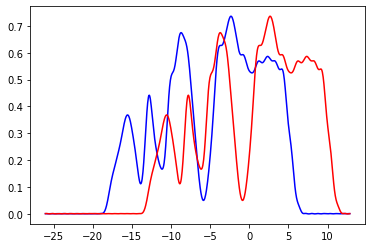

In [5]:
energies = full_eigen_energies
emin = -24.553719539983 - 1.5
emax = 11.346414696331 + 1.5
num_frequencies = 50
smearing = 0.3

# Compute Fourier coefficients
t0 = time.time()
coeffs = []
for i in tqdm(full_eigen_energies):
    coeffs_i = fourier_transform_dos(i, emin, emax, num_frequencies, smearing)
    coeffs.append(coeffs_i)

coeffs = torch.vstack(coeffs)
coeffs = ((coeffs.T * normalization).T) * 2
# Print required time
dt = time.time()-t0
print(f'Computed {num_frequencies} complex Fourier coeffs.')
print(f'  --> corresponds to {2*num_frequencies-1} real coeffs.')
print(f'\nDuration = {dt:6.4f}s')
# print(f'Estimate for 5000 frames = {5000*dt:5.1f}s = {500/6*dt:3.2f}min')

# Evaluate DOS and plot

f_ldos = evaluate_dos_from_fourier(coeffs, emin, emax, num_eval=778)
ene_plot = np.linspace(emin, emax, len(f_ldos[0]))
plt.plot(ene_plot, f_ldos[0], c= 'b')
# plt.plot(xdos, ldos[0])

# Plot shifted version as well
coeffs_shifted = shift_coeffs(coeffs[:1], emin, emax, delta=torch.tensor([5]))
dos_shifted = evaluate_dos_from_fourier(coeffs_shifted, emin, emax, num_eval=778)
plt.plot(ene_plot, dos_shifted[0], c= 'r')

## Biased Train-test split

In [6]:
#Selected Amorphous structures

amorph_train = np.arange(939,1039,1)
np.random.seed(0)
np.random.shuffle(amorph_train)

amorph_test = amorph_train[:80]
amorph_train = amorph_train[80:]

n_structures2 = 939
np.random.seed(0)
n_train = int(0.8 * 1039)-20
remaining_train_index = np.arange(n_structures2)
np.random.shuffle(remaining_train_index)

remaining_test_index = remaining_train_index[n_train:]
remaining_train_index = remaining_train_index[:n_train]

biased_train_index = np.concatenate([remaining_train_index, amorph_train])
biased_test_index = np.concatenate([remaining_test_index, amorph_test])

In [7]:
# Fermi level
import ase

T_0 = 200
beta_0 = 1 / (ase.units.kB * T_0) # inverse temperature
efermi = torch.zeros(n_structures)
for i in range(n_structures):
    efermi[i] = torch.tensor(utils.getmu(ldos[i], beta_0, xdos, n=4))

In [8]:
cutoff = torch.max(efermi) + 3
cutoff_index = torch.searchsorted(xdos, cutoff)

## Test Loss function

In [9]:
def MSE_shift_fourier(x_pred, target, n_epochs):
    shifts = torch.nn.parameter.Parameter(torch.zeros(target.shape[0]))
    opt_LBFGS = torch.optim.LBFGS([shifts], lr = 1, line_search_fn = 'strong_wolfe', tolerance_grad = 1e-15, tolerance_change = 1e-15)#, weight_decay = 0)
    opt_adam = torch.optim.Adam([shifts], lr = 1e-2, weight_decay = 0)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt_adam, factor = 0.1, patience = 20, threshold = 1e-7, min_lr = 1e-7)
   
    for i in range(n_epochs):
        def closure():
            opt_LBFGS.zero_grad()
            shifted_preds = shift_coeffs(x_pred, emin, emax, shifts)
#             shifted_ldos = evaluate_dos_from_fourier(shifted_preds, emin, emax, num_eval=778)
            loss_i = torch.mean(abs(shifted_preds- target)**2) 
#             loss_i = loss.t_get_mse(shifted_ldos[:,cutoff_index], target[:,cutoff_index])
            loss_i.backward(gradient = torch.tensor(1), inputs = shifts )
            return (loss_i)

        mse = opt_LBFGS.step(closure)
        
    return mse, shifts

In [10]:
# true_alignments = true_alignments.clone()#(torch.rand(1039)-0.5) * 8
# shifted_target = shift_coeffs(coeffs, emin ,emax, true_alignments)
# error, align = MSE_shift_fourier(shifted_target, coeffs, 5)
# torch.where(abs(true_alignments + align)>1e-3 )

In [11]:
# i=0
# shifted_dos = evaluate_dos_from_fourier(shifted_target[i:i+1], emin, emax, num_eval=778)
# predicted_shifted_dos = evaluate_dos_from_fourier(shift_coeffs(coeffs[i:i+1], emin, emax, -1 * align[i:i+1]) , emin, emax, num_eval=778)
# plt.plot(xdos, shifted_dos[0], c = 'r')
# plt.plot(xdos, predicted_shifted_dos[0].detach(), c = 'b')

## Features Generation

In [12]:
import rascaline
from skcosmo.feature_selection import FPS
import scipy

HYPER_PARAMETERS = {
    "cutoff": 4.0,#6.0,#4.0,
    "max_radial": 8,#12,#8,
    "max_angular": 6,#9,#6,
    "atomic_gaussian_width": 0.45,
    "center_atom_weight": 1.0,
    "radial_basis":{
        "Gto":{}
    },
    "cutoff_function":{
        "Step":{}, #maybe 
    },
    "radial_scaling":{
        "Willatt2018":{
        'exponent': 5,
        'rate' : 1,
        'scale' : 3.,
        },
    },
}

calculator = rascaline.SoapPowerSpectrum(**HYPER_PARAMETERS)
descriptors = calculator.compute(structures)
descriptors.keys_to_samples("species_center")
descriptors.keys_to_properties(["species_neighbor_1", "species_neighbor_2"])



n_refs = 200
n_atoms = descriptors.block(0).values.shape[0]
n_structures = np.unique(descriptors.block(0).samples["structure"])
feature = torch.zeros(len(n_structures), n_refs)
atom_descriptors = torch.tensor(descriptors.block(0).values)
atom_descriptors = torch.nn.functional.normalize(atom_descriptors, dim = 1)
selector = FPS(n_to_select = n_refs,
           progress_bar = True,
           score_threshold = 1e-12,
           full = False,
           initialize = 0
          )
selector.fit(atom_descriptors.T)
references = selector.transform(atom_descriptors.T).T
atomkernel_descriptors = torch.pow(atom_descriptors @ references.T, 2)
for structure_i in n_structures:
    a_i = descriptors.block(0).samples["structure"] == structure_i
    feature[structure_i, :] = torch.sum(atomkernel_descriptors[a_i, :], axis = 0)/np.sum(a_i)

kMM = references @ references.T
rtkMM = scipy.linalg.sqrtm(kMM)

  0%|          | 0/199 [00:00<?, ?it/s]

## Gradient training Unbiased


In [13]:
model = torch.nn.Linear(201, 50, bias = False, dtype = torch.complex128)


In [14]:
model.weight

Parameter containing:
tensor([[ 0.0445+0.0234j,  0.0155+0.0461j,  0.0373+0.0368j,  ...,
          0.0245+0.0331j,  0.0497+0.0127j, -0.0269-0.0124j],
        [ 0.0430-0.0267j,  0.0096-0.0662j, -0.0204+0.0344j,  ...,
         -0.0266-0.0451j, -0.0181+0.0441j, -0.0167+0.0413j],
        [ 0.0101-0.0358j,  0.0425+0.0009j, -0.0496+0.0135j,  ...,
          0.0005+0.0623j, -0.0497-0.0247j, -0.0334+0.0502j],
        ...,
        [-0.0615+0.0460j,  0.0307-0.0009j,  0.0646+0.0071j,  ...,
         -0.0615+0.0571j, -0.0400+0.0170j,  0.0155+0.0339j],
        [ 0.0174-0.0435j, -0.0638+0.0602j, -0.0226-0.0511j,  ...,
         -0.0474-0.0520j, -0.0308+0.0080j,  0.0030+0.0320j],
        [-0.0434+0.0245j,  0.0235-0.0340j, -0.0551-0.0100j,  ...,
          0.0090-0.0357j, -0.0599+0.0350j,  0.0239+0.0334j]],
       requires_grad=True)

In [15]:
for i in model.parameters():
    print (i)

Parameter containing:
tensor([[ 0.0445+0.0234j,  0.0155+0.0461j,  0.0373+0.0368j,  ...,
          0.0245+0.0331j,  0.0497+0.0127j, -0.0269-0.0124j],
        [ 0.0430-0.0267j,  0.0096-0.0662j, -0.0204+0.0344j,  ...,
         -0.0266-0.0451j, -0.0181+0.0441j, -0.0167+0.0413j],
        [ 0.0101-0.0358j,  0.0425+0.0009j, -0.0496+0.0135j,  ...,
          0.0005+0.0623j, -0.0497-0.0247j, -0.0334+0.0502j],
        ...,
        [-0.0615+0.0460j,  0.0307-0.0009j,  0.0646+0.0071j,  ...,
         -0.0615+0.0571j, -0.0400+0.0170j,  0.0155+0.0339j],
        [ 0.0174-0.0435j, -0.0638+0.0602j, -0.0226-0.0511j,  ...,
         -0.0474-0.0520j, -0.0308+0.0080j,  0.0030+0.0320j],
        [-0.0434+0.0245j,  0.0235-0.0340j, -0.0551-0.0100j,  ...,
          0.0090-0.0357j, -0.0599+0.0350j,  0.0239+0.0334j]],
       requires_grad=True)


In [18]:
from dostools.loss import loss
#normal dataset

batch_size = 64
sigma = 0.3
n_epochs = 100000
patience = 20

index = train_index
t_index = test_index

Sampler = torch.utils.data.RandomSampler(index, replacement = False)
Batcher = torch.utils.data.BatchSampler(Sampler, batch_size, False)

Features = torch.hstack([feature[index].double(), torch.ones(len(index)).view(-1,1)]).type(dtype = torch.complex128)
t_Features = torch.hstack([feature[t_index].double(), torch.ones(len(t_index)).view(-1,1)]).type(dtype = torch.complex128)
# Features = torch.hstack([Silicon.Features['structure_avedescriptors'][index].double(), torch.ones(len(index)).view(-1,1)])
# t_Features = torch.hstack([Silicon.Features['structure_avedescriptors'][t_index].double(), torch.ones(len(t_index)).view(-1,1)])
alignment = torch.nn.parameter.Parameter(torch.zeros(len(index)))

opt = torch.optim.Adam([alignment, model.weight], lr = 1e-3, weight_decay = 0)
# opt_LBFGS = torch.optim.LBFGS([alignment], lr = 1e-3, line_search_fn = 'strong_wolfe', tolerance_grad = 1e-15, tolerance_change = 1e-15)#, weight_decay = 0)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor = 0.1, patience = 50, threshold = 1e-5, min_lr = 1e-8)

xdos_i = xdos.clone()
# cutoff = torch.max(efermi) + 3
# cutoff_index = torch.searchsorted(xdos, cutoff)

train_ldos = coeffs[index,:].clone()#n_ldos2[index,:cutoff_index].clone()

best_mse = torch.tensor(100)
best_state = alignment.clone()

n_col = Features.shape[1]
regularization = 1

reg = torch.hstack([torch.real(torch.tensor(regularization * rtkMM)), torch.zeros(rtkMM.shape[0]).view(-1,1)])
reg = torch.vstack([reg, torch.zeros(n_col)])


reg_features = torch.vstack([Features, reg])
reg_target = torch.vstack([train_ldos, torch.zeros(n_col,train_ldos.shape[1])])
reference_weights = torch.linalg.lstsq(reg_features, reg_target, driver = "gelsd", rcond = 1e-10).solution
reference_pred = Features @ reference_weights
reference_t_pred = t_Features @ reference_weights



train_loss = torch.mean(abs(reference_pred- train_ldos)**2) 
test_loss = torch.mean(abs(reference_t_pred- coeffs[test_index])**2) 
current_rmse = torch.tensor(100)
pred_loss = torch.tensor(100)
prev_loss = torch.tensor(100)
trigger = 0
print ("Reference training loss: {:.6}".format(train_loss))
print ("Reference test loss : {:.6}".format(test_loss))

pbar = tqdm(range(n_epochs))
for epoch in pbar:
    pbar.set_description(f"Epoch: {epoch}")
    pbar.set_postfix(pred_loss = pred_loss.item(), lowest_mse = best_mse.item(), lr = opt.param_groups[0]['lr'],trigger = trigger)
    for i_batch in Batcher:
        def closure():
            opt.zero_grad()
            reg_features_i = torch.vstack([Features[i_batch], reg])
            shifted_target = shift_coeffs(train_ldos[i_batch], emin, emax, alignment[i_batch])            
            shifted_reg_target = torch.vstack([shifted_target, torch.zeros(n_col,train_ldos.shape[1])])             
            shifted_train_preds = reg_features_i @ model.weight.T
            loss_i = torch.mean(abs(shifted_train_preds - shifted_reg_target)**2) 
            loss_i.backward()
            return loss_i
        opt.step(closure)
        train_ldos = train_ldos.detach()
        
    with torch.no_grad():
        shifted_target = shift_coeffs(train_ldos, emin, emax, alignment)
        shifted_reg_target = torch.vstack([shifted_target, torch.zeros(n_col,train_ldos.shape[1])])          
        train_weights = torch.linalg.lstsq(reg_features, shifted_reg_target, rcond = 1e-10, driver = "gelsd").solution
        pred_i = Features @ model.weight.T
        
        
        i_loss = torch.mean(abs(pred_i - shifted_target)**2) 
       
        pred_loss = i_loss
        if i_loss < prev_loss * (1 + 1e-3): 
            trigger = 0
        else:
            trigger +=1 
            if trigger >= patience:
                alignment = torch.nn.parameter.Parameter(best_state)
                opt = torch.optim.Adam([alignment], lr = opt.param_groups[0]['lr'], weight_decay = 0)
                counter = 0

        if i_loss < best_mse:
            best_mse = i_loss
            best_state = alignment.clone()

        prev_loss = i_loss

        scheduler.step(i_loss)
        if opt.param_groups[0]['lr'] < 1e-4 and batch_size == 1024:
            break
            
        if opt.param_groups[0]['lr'] < 1e-4 and batch_size < 1024:            
            Batcher.batch_size *= 2 
            opt.param_groups[0]['lr'] = 1e-3
            print ("The batch_size is now:", Batcher.batch_size)


            
            


shifted_target = shift_coeffs(train_ldos, emin, emax, best_state)    
shifted_reg_target = torch.vstack([shifted_target, torch.zeros(n_col,train_ldos.shape[1])])   


shifted_weights = torch.linalg.lstsq(reg_features, shifted_reg_target, driver = "gelsd").solution
shifted_preds = Features @ shifted_weights
shifted_t_preds = t_Features @ shifted_weights


shifted_train_loss = torch.mean(abs(shifted_preds - shifted_target)**2)#loss.t_get_rmse(shifted_preds, shifted_target, xdos, perc = True)
# shifted_test_loss = loss.t_get_rmse(shifted_t_preds, shifted_ldos, xdos, perc = True) Need the one with the new loss function

print ("Final training loss: {:.6}".format(shifted_train_loss))


Reference training loss: 0.0015957
Reference test loss : 0.00222239


Epoch: 4911:   5%|████▋                                                                                          | 4911/100000 [03:45<1:11:55, 22.03it/s, lowest_mse=0.0225, lr=0.001, pred_loss=0.0495, trigger=0]

The batch_size is now: 1024


Epoch: 68957:  69%|██████████████████████████████████████████████████████████████████▏                             | 68956/100000 [47:24<20:22, 25.38it/s, lowest_mse=0.0176, lr=0.001, pred_loss=0.165, trigger=1]

The batch_size is now: 2048


Epoch: 69059:  69%|█████████████████████████████████████████████████████████████████▌                             | 69057/100000 [47:29<20:27, 25.21it/s, lowest_mse=0.0176, lr=0.001, pred_loss=0.0176, trigger=0]

The batch_size is now: 4096


Epoch: 69254:  69%|█████████████████████████████████████████████████████████████████▊                             | 69252/100000 [47:37<20:29, 25.01it/s, lowest_mse=0.0176, lr=0.001, pred_loss=0.0176, trigger=0]

The batch_size is now: 8192


Epoch: 69377:  69%|█████████████████████████████████████████████████████████████████▉                             | 69378/100000 [47:42<20:20, 25.09it/s, lowest_mse=0.0176, lr=0.001, pred_loss=0.0176, trigger=0]

The batch_size is now: 16384


Epoch: 69497:  69%|██████████████████████████████████████████████████████████████████                             | 69495/100000 [47:47<20:06, 25.29it/s, lowest_mse=0.0176, lr=0.001, pred_loss=0.0176, trigger=0]

The batch_size is now: 32768


Epoch: 69612:  70%|██████████████████████████████████████████████████████████████████▏                            | 69612/100000 [47:51<20:06, 25.18it/s, lowest_mse=0.0176, lr=0.001, pred_loss=0.0176, trigger=0]

The batch_size is now: 65536


Epoch: 69722:  70%|██████████████████████████████████████████████████████████████████▏                            | 69720/100000 [47:56<20:10, 25.01it/s, lowest_mse=0.0176, lr=0.001, pred_loss=0.0176, trigger=0]

The batch_size is now: 131072


Epoch: 69830:  70%|██████████████████████████████████████████████████████████████████▎                            | 69828/100000 [48:00<20:13, 24.87it/s, lowest_mse=0.0176, lr=0.001, pred_loss=0.0176, trigger=0]

The batch_size is now: 262144


Epoch: 69980:  70%|██████████████████████████████████████████████████████████████████▍                            | 69978/100000 [48:06<20:17, 24.65it/s, lowest_mse=0.0176, lr=0.001, pred_loss=0.0176, trigger=0]

The batch_size is now: 524288


Epoch: 72400:  72%|████████████████████████████████████████████████████████████████████▊                          | 72400/100000 [51:48<19:28, 23.62it/s, lowest_mse=0.0176, lr=0.001, pred_loss=0.0176, trigger=0]

The batch_size is now: 1048576


Epoch: 72548:  73%|████████████████████████████████████████████████████████████████████▉                          | 72547/100000 [51:54<20:24, 22.42it/s, lowest_mse=0.0176, lr=0.001, pred_loss=0.0176, trigger=0]

The batch_size is now: 2097152


Epoch: 72696:  73%|█████████████████████████████████████████████████████████████████████                          | 72694/100000 [52:01<21:06, 21.57it/s, lowest_mse=0.0176, lr=0.001, pred_loss=0.0176, trigger=0]

The batch_size is now: 4194304


Epoch: 72878:  73%|█████████████████████████████████████████████████████████████████████▏                         | 72877/100000 [52:14<32:16, 14.01it/s, lowest_mse=0.0176, lr=0.001, pred_loss=0.0176, trigger=0]

The batch_size is now: 8388608


Epoch: 73039:  73%|█████████████████████████████████████████████████████████████████████▍                         | 73039/100000 [52:31<53:32,  8.39it/s, lowest_mse=0.0176, lr=0.001, pred_loss=0.0176, trigger=0]

The batch_size is now: 16777216


Epoch: 73193:  73%|████████████████████████████████████████████████████████████████████                         | 73193/100000 [52:56<1:11:49,  6.22it/s, lowest_mse=0.0176, lr=0.001, pred_loss=0.0176, trigger=0]

The batch_size is now: 33554432


Epoch: 73343:  73%|████████████████████████████████████████████████████████████████████▏                        | 73343/100000 [53:38<2:04:46,  3.56it/s, lowest_mse=0.0176, lr=0.001, pred_loss=0.0176, trigger=0]

The batch_size is now: 67108864


Epoch: 73502:  74%|████████████████████████████████████████████████████████████████████▎                        | 73502/100000 [55:03<4:04:39,  1.81it/s, lowest_mse=0.0176, lr=0.001, pred_loss=0.0176, trigger=0]

The batch_size is now: 134217728


Epoch: 73655:  74%|████████████████████████████████████████████████████████████████████▍                        | 73655/100000 [58:33<8:22:44,  1.14s/it, lowest_mse=0.0176, lr=0.001, pred_loss=0.0176, trigger=0]

The batch_size is now: 268435456


Epoch: 73835:  74%|██████████████████████████████████████████████████████████████████▍                       | 73835/100000 [1:06:05<15:45:58,  2.17s/it, lowest_mse=0.0176, lr=0.001, pred_loss=0.0176, trigger=0]

The batch_size is now: 536870912


Epoch: 74003:  74%|██████████████████████████████████████████████████████████████████▌                       | 74003/100000 [1:17:35<29:14:31,  4.05s/it, lowest_mse=0.0176, lr=0.001, pred_loss=0.0176, trigger=0]

The batch_size is now: 1073741824


Epoch: 74163:  74%|██████████████████████████████████████████████████████████████████▋                       | 74163/100000 [1:39:13<56:25:13,  7.86s/it, lowest_mse=0.0176, lr=0.001, pred_loss=0.0176, trigger=0]

The batch_size is now: 2147483648


Epoch: 74322:  74%|██████████████████████████████████████████████████████████████████▏                      | 74322/100000 [2:25:17<122:04:49, 17.12s/it, lowest_mse=0.0176, lr=0.001, pred_loss=0.0176, trigger=0]

The batch_size is now: 4294967296


Epoch: 74381:  74%|█████████████████████████████████████████████████████████████████▍                      | 74381/100000 [3:04:56<278:34:21, 39.15s/it, lowest_mse=0.0176, lr=0.0001, pred_loss=0.0176, trigger=0]Exception ignored in: <generator object tqdm.__iter__ at 0x7fc6f06870b0>
Traceback (most recent call last):
  File "/home/how/anaconda3/lib/python3.9/site-packages/tqdm/std.py", line 1196, in __iter__
    yield obj
KeyboardInterrupt: 


KeyboardInterrupt: 

In [ ]:
5

## Dataset and Dataloader

In [10]:
from torch.utils.data import Dataset
class ShiftingDataset(Dataset):
    def __init__(self, X, y_coeff, y_eigval, normalization, xdos):
        self.X = X
        self.y_coeff = y_coeff
        self.y_eigval = y_eigval
        self.normalization = normalization
        self.alignment = torch.nn.parameter.Parameter(torch.zeros(len(X)))
        self.xdos = xdos
        
        
    def __len__(self):
        return len(self.X)
    
    def project_dos(self, idx):
        new_dos = (torch.sum((self.y_coeff[idx].view(1, -1, 687) * (torch.exp(-0.5*((self.alignment[idx].view(1,-1,1) + self.xdos.view(-1,1,1) - self.y_eigval[idx])/sigma)**2))), dim = 2)).T * self.normalization[idx].view(-1,1) * 2
        return new_dos.squeeze()
    
    def __getitem__(self, idx):
        y = self.project_dos(idx)
        return self.X[idx], y.double()
        

In [ ]:
Silicon.Features['structure_avedescriptors']

In [12]:
from torch.utils.data import TensorDataset, DataLoader
# soap_dataset = ShiftingDataset(Silicon.Features['structure_avedescriptors'][:10].double(), structure_coefficients_t[:10], structure_eigvals_t[:10], normalization[:10], xdos)
soap_dataset = ShiftingDataset(Silicon.Features['structure_avedescriptors'][train_index].double(), structure_coefficients_t[train_index], structure_eigvals_t[train_index], normalization[train_index], xdos)
device = 'cpu'
kwargs = {"pin_memory":True} if device == "cuda:0" else {}
soap_dataloader = DataLoader(soap_dataset, batch_size = 8, shuffle = True,**kwargs)

In [89]:
def evaluate_performance(new_dos):
    Features = torch.hstack([Silicon.Features['structure_avedescriptors'][train_index].double(), torch.ones(len(train_index)).view(-1,1)])
    Target = new_dos
    
    optimal_weights = torch.linalg.lstsq(Features, Target, driver = 'gelsd').solution
    preds = Features @ optimal_weights 
    
    train_loss = loss.t_get_rmse(preds, new_dos)
    
    return train_loss

In [90]:
evaluate_performance(y_pw[train_index])

tensor(0.0078)

In [70]:
import dostools.loss.loss as loss

#alignment = torch.nn.parameter.Parameter(torch.zeros(len(train_index)))
lr = 0.01
sigma = 0.3
n_epochs = 100000
optimizer = torch.optim.Adam(
        [alignment],
        lr=lr)#,  line_search_fn="strong_wolfe")


scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, patience = 30)#0.5)

for epoch in tqdm(range(n_epochs)):
    optimizer.zero_grad()
    new_dos = (torch.sum((structure_coefficients_t[train_index].view(1, 831, 687) * (torch.exp(-0.5*((alignment.view(1,-1,1) + xdos.view(-1,1,1) - structure_eigvals_t[train_index])/sigma)**2))), dim = 2)).T * normalization[train_index].view(-1,1) * 2
    train_loss = evaluate_performance(new_dos)
    train_loss.backward()
    optimizer.step()
    scheduler.step(train_loss)
    print ("Sum Abs Shift is {}".format(torch.sum(torch.abs(alignment))))
    print ("The train_loss at epoch {} is : {}".format(epoch, train_loss))
#     with torch.no_grad():
#         new_dos = (torch.sum((structure_coefficients_t[train_index].view(1, 831, 687) * (torch.exp(-0.5*((alignment.view(1,-1,1) + xdos.view(-1,1,1) - structure_eigvals_t[train_index])/sigma)**2))), dim = 2)).T * normalization[train_index].view(-1,1) * 2
#         train_loss = evaluate_performance(new_dos)
#         all_losses.append(pc_loss)
#         all_train_loss.append(train_loss)


  0%|                                                                                                                                                                       | 1/100000 [00:07<205:34:51,  7.40s/it]

Sum Abs Shift is 309.30228608258284
The train_loss at epoch 0 is : 0.0028419422801208823


  0%|                                                                                                                                                                       | 2/100000 [00:14<200:13:05,  7.21s/it]

Sum Abs Shift is 310.43180080964316
The train_loss at epoch 1 is : 0.0028416597027839776


  0%|                                                                                                                                                                       | 2/100000 [00:21<298:52:19, 10.76s/it]


KeyboardInterrupt: 

In [44]:
# torch.save(alignment, "./AnalyticalAlignment.pt")

<IPython.core.display.Javascript object>


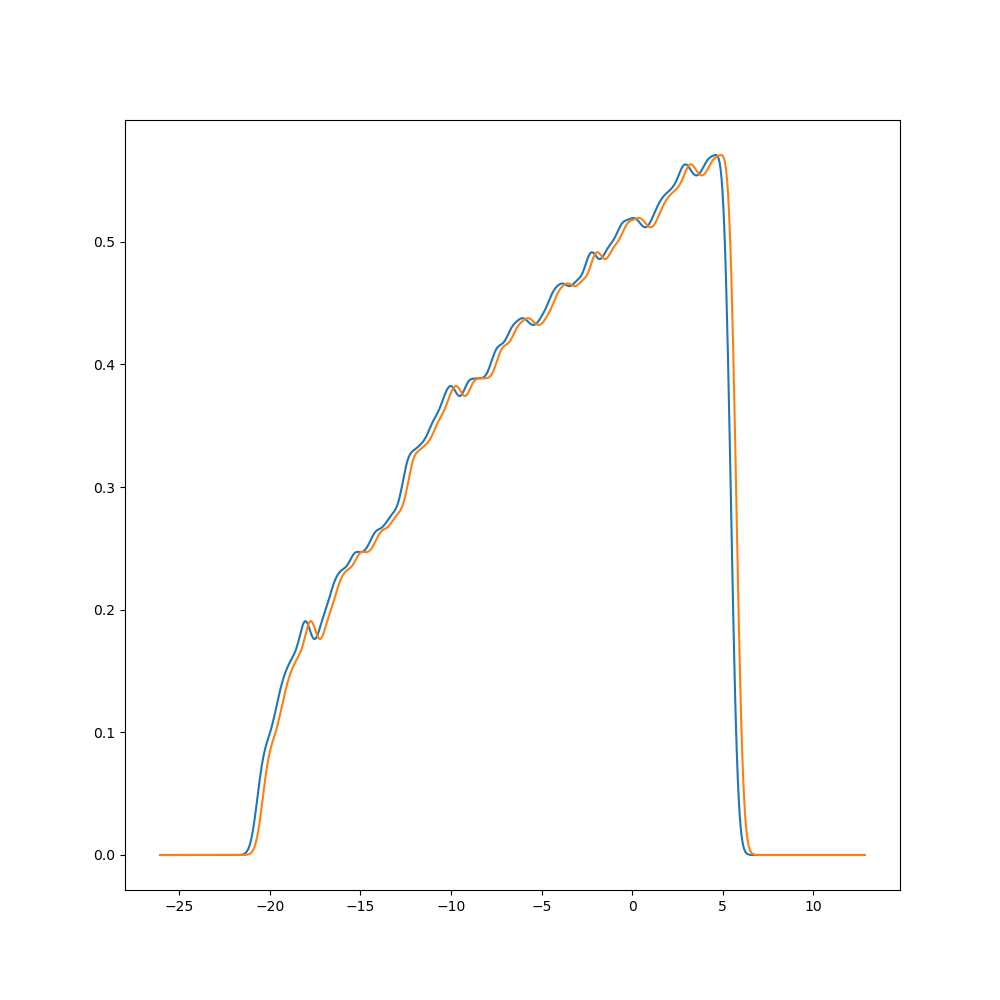

In [80]:
plt.plot(xdos, original_dos[train_index[0]].detach())
plt.plot(xdos, new_dos[0].detach())

In [61]:
new_dos = (torch.sum((structure_coefficients_t[train_index].view(1, 831, 687) * (torch.exp(-0.5*((alignment.view(1,-1,1) + xdos.view(-1,1,1) - structure_eigvals_t[train_index])/sigma)**2))), dim = 2)).T * normalization[train_index].view(-1,1) * 2

In [66]:
original_dos = (torch.sum((structure_coefficients_t.view(1, 1039, 687) * (torch.exp(-0.5*((xdos.view(-1,1,1) - structure_eigvals_t)/sigma)**2))), dim = 2)).T * normalization.view(-1,1) * 2

In [78]:
#def evaluate_performance(new_dos):
with torch.no_grad():
    Features = torch.hstack([Silicon.Features['structure_avedescriptors'][train_index].double(), torch.ones(len(train_index)).view(-1,1)])
    Target = new_dos
    optimal_weights = torch.linalg.lstsq(Features, Target, driver = 'gelsd').solution
    Total_Features = torch.hstack([Silicon.Features['structure_avedescriptors'].double(), torch.ones(len(Silicon.Features['structure_avedescriptors'])).view(-1,1)])
    print ("training over")
    shift_range = torch.tensor([0.05 * a for a in torch.arange(-80,80)])
    Total_preds = Total_Features @ optimal_weights
    train_loss = loss.t_get_rmse(Total_preds[train_index],new_dos, xdos, perc = False)

   
    atrain_loss, atrain_indexes = loss.t_get_BF_shift_index_error(Total_preds[train_index], original_dos[train_index], shift_range, xdos, perc = True)
    atest_loss, atest_indexes = loss.t_get_BF_shift_index_error(Total_preds[test_index], original_dos[test_index], shift_range, xdos, perc = True)
    atotal_loss, atotal_indexes = loss.t_get_BF_shift_index_error(Total_preds, original_dos, shift_range, xdos, perc = True)
print (train_loss) 
print (train_loss * 100 / std_train)
print (atrain_loss)
print (atrain_loss * std_train /100)
print (atest_loss)
print (atest_loss * std_test / 100)
print (atotal_loss)
print (atotal_loss * std_all/ 100)

training over
tensor(0.0237)
tensor(4.0270)
tensor(5.0532)
tensor(0.0297)
tensor(18.7668)
tensor(0.1143)
tensor(7.8684)
tensor(0.0466)


In [69]:
#def evaluate_performance(new_dos):
with torch.no_grad():
    Features = torch.hstack([Silicon.Features['structure_avedescriptors'][train_index].double(), torch.ones(len(train_index)).view(-1,1)])
    Target = original_dos[train_index]
    optimal_weights = torch.linalg.lstsq(Features, Target, driver = 'gelsd').solution
    Total_Features = torch.hstack([Silicon.Features['structure_avedescriptors'].double(), torch.ones(len(Silicon.Features['structure_avedescriptors'])).view(-1,1)])
    print ("training over")
    shift_range = torch.tensor([0.05 * a for a in torch.arange(-80,80)])
    Total_preds = Total_Features @ optimal_weights
    atrain_loss, atrain_indexes = loss.t_get_BF_shift_index_error(Total_preds[train_index], original_dos[train_index], shift_range, xdos, perc = True)
    atest_loss, atest_indexes = loss.t_get_BF_shift_index_error(Total_preds[test_index], original_dos[test_index], shift_range, xdos, perc = True)
    atotal_loss, atotal_indexes = loss.t_get_BF_shift_index_error(Total_preds, original_dos, shift_range, xdos, perc = True)

print (atrain_loss)
print (atrain_loss * std_train /100)
print (atest_loss)
print (atest_loss * std_test / 100)
print (atotal_loss)
print (atotal_loss * std_all/ 100)

training over
tensor(4.6877)
tensor(0.0276)
tensor(16.7858)
tensor(0.1022)
tensor(7.1720)
tensor(0.0425)


In [46]:
#use alignment to make full dataset
sigma = 0.3
dx = 0.05

emin = -24.5537
emax = 11.3464


ndos = int((emax-emin+3) / dx) #number of points
xdos = np.linspace(emin-1.5, emax+1.5, ndos) # extend the energy grid by 3eV 
final_ldos = []
with torch.no_grad():
    for i in tqdm(range(len(train_index))):#for every structure    
        i_ldos = np.zeros(ndos)
        for j in (full_eigen_energies[train_index[i]]):
            i_ldos += (np.exp(-0.5*((alignment[i].detach().numpy() + xdos - j.numpy())/sigma)**2))
        final_ldos.append(i_ldos * normalization[train_index[i]].detach().numpy() * 2)

#final_ldos = ((ldos.T * normalization ).T)* 2
final_ldos = np.vstack(final_ldos) 

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 831/831 [04:28<00:00,  3.10it/s]


In [49]:
final_ldos = torch.tensor(final_ldos)
xdos = torch.tensor(xdos)

/tmp/ipykernel_22844/2007586663.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  final_ldos = torch.tensor(final_ldos)


In [50]:
#def evaluate_performance(new_dos):
with torch.no_grad():
    Features = torch.hstack([Silicon.Features['structure_avedescriptors'][train_index].double(), torch.ones(len(train_index)).view(-1,1)])
    Target = final_ldos
    optimal_weights = torch.linalg.lstsq(Features, Target, driver = 'gelsd').solution
    Total_Features = torch.hstack([Silicon.Features['structure_avedescriptors'].double(), torch.ones(len(Silicon.Features['structure_avedescriptors'])).view(-1,1)])
    print ("training over")
    shift_range = torch.tensor([0.05 * a for a in torch.arange(-80,80)])
    Total_preds = Total_Features @ optimal_weights
    atrain_loss, atrain_indexes = loss.t_get_BF_shift_index_error(Total_preds[train_index], ldos[train_index], shift_range, xdos, perc = True)
    atest_loss, atest_indexes = loss.t_get_BF_shift_index_error(Total_preds[test_index], ldos[test_index], shift_range, xdos, perc = True)
    atotal_loss, atotal_indexes = loss.t_get_BF_shift_index_error(Total_preds, ldos, shift_range, xdos, perc = True)

print (atrain_loss)
print (atrain_loss * std_train /100)
print (atest_loss)
print (atest_loss * std_test / 100)
print (atotal_loss)
print (atotal_loss * std_all/ 100)

training over
tensor(5.2625)


NameError: name 'std_train' is not defined

In [51]:
mldos = ldos[train_index].mean(axis = 0)
std_train = torch.sqrt((torch.trapezoid((ldos[train_index] - mldos)**2, xdos, axis=1)).mean())
mldos = ldos[test_index].mean(axis = 0)
std_test = torch.sqrt((torch.trapezoid((ldos[test_index] - mldos)**2, xdos, axis=1)).mean())
mldos = ldos.mean(axis = 0)
std_all = torch.sqrt((torch.trapezoid((ldos - mldos)**2, xdos, axis=1)).mean())

In [52]:
print (atrain_loss)
print (atrain_loss * std_train /100)
print (atest_loss)
print (atest_loss * std_test / 100)
print (atotal_loss)
print (atotal_loss * std_all/ 100)

tensor(5.2625)
tensor(0.0309)
tensor(18.8763)
tensor(0.1150)
tensor(8.0578)
tensor(0.0477)


<IPython.core.display.Javascript object>


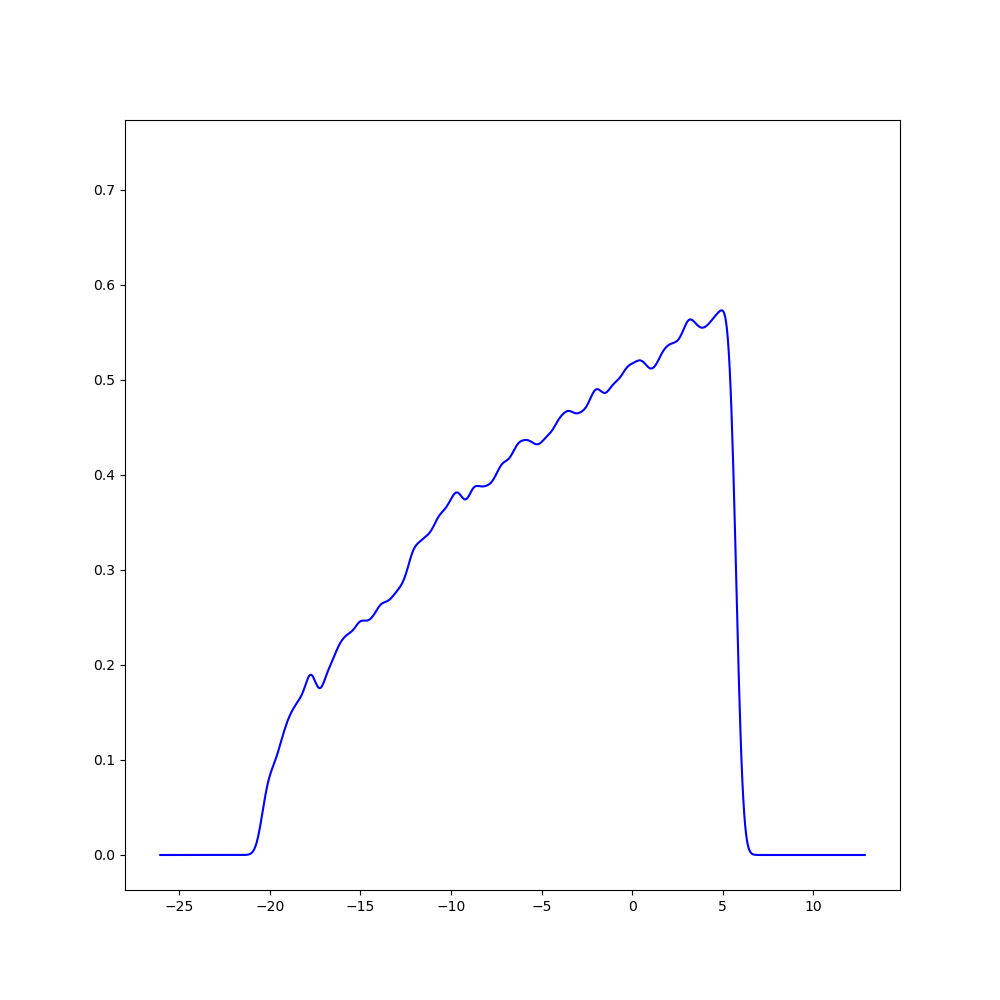

In [54]:
plt.plot(xdos,ldos[0], ' r')
plt.plot(xdos, final_ldos[0], 'b')

In [56]:
#def evaluate_performance(new_dos):
with torch.no_grad():
    Features = torch.hstack([Silicon.Features['structure_avedescriptors'][train_index].double(), torch.ones(len(train_index)).view(-1,1)])
    Target = ldos[train_index]
    optimal_weights = torch.linalg.lstsq(Features, Target, driver = 'gelsd').solution
    Total_Features = torch.hstack([Silicon.Features['structure_avedescriptors'].double(), torch.ones(len(Silicon.Features['structure_avedescriptors'])).view(-1,1)])
    print ("training over")
    shift_range = torch.tensor([0.05 * a for a in torch.arange(-80,80)])
    Total_preds = Total_Features @ optimal_weights
    atrain_loss, atrain_indexes = loss.t_get_BF_shift_index_error(Total_preds[train_index], ldos[train_index], shift_range, xdos, perc = True)
    atest_loss, atest_indexes = loss.t_get_BF_shift_index_error(Total_preds[test_index], ldos[test_index], shift_range, xdos, perc = True)
    atotal_loss, atotal_indexes = loss.t_get_BF_shift_index_error(Total_preds, ldos, shift_range, xdos, perc = True)

training over


In [57]:
print (atrain_loss)
print (atrain_loss * std_train /100)
print (atest_loss)
print (atest_loss * std_test / 100)
print (atotal_loss)
print (atotal_loss * std_all/ 100)

tensor(4.6573)
tensor(0.0274)
tensor(16.6243)
tensor(0.1012)
tensor(7.1146)
tensor(0.0422)


In [45]:
alignment

Parameter containing:
tensor([-2.9639e-01, -5.7539e-01, -8.2470e-02,  3.2733e-01,  2.9278e-01,
        -7.2505e-01,  3.5750e-01,  3.0807e-01,  4.6900e-01,  4.4480e-01,
         5.4264e-01, -5.7500e-01, -5.7564e-01,  3.2466e-01,  1.2950e-03,
         3.8769e-01,  1.9227e-02, -5.7878e-01,  2.6678e-01,  6.3790e-02,
         7.9235e-01,  7.4678e-01,  8.3032e-02,  6.3051e-01,  9.8185e-02,
         6.3358e-02,  4.5548e-01,  4.0455e-01, -4.0441e-01,  3.3609e-01,
         5.4146e-01,  5.5846e-01,  7.4355e-01,  2.1774e-02,  9.4818e-03,
         1.2900e-02,  9.1110e-02,  2.6543e-01,  3.9306e-01,  1.9596e-01,
         4.3141e-01,  5.4021e-01, -3.2833e-01,  2.4779e-02,  7.6010e-01,
         3.3652e-01,  3.7426e-02,  8.2604e-01,  8.3756e-01,  6.6422e-01,
         1.3426e-01,  4.0620e-01,  5.7230e-01,  2.4209e-01,  4.7780e-01,
         8.0519e-02,  5.6949e-01,  4.4432e-01,  6.6716e-01,  3.3711e-02,
         1.1962e-01,  1.6069e-01,  2.0177e-02,  3.5727e-01,  4.5952e-01,
         3.7165e-01,  7.6293e

In [97]:
for x,y in soap_dataloader:
    print (x.shape)
    print (y.shape)
    break

torch.Size([8, 448])
torch.Size([8, 778])


## Model

In [98]:
import dostools.models.models as models
import dostools.models.training as training
import dostools.models.architectures as architecture
import dostools.loss.loss as loss
import torch.nn as nn

importlib.reload(models)
importlib.reload(training)
importlib.reload(architecture)
importlib.reload(loss)

#can consider normalization layer here, start with bias and stuff first

class WassLinearModel(nn.Module):
    def __init__(self, inputSize, outputSize, xdos, device):
        super(WassLinearModel, self).__init__()
        self.linear = nn.Linear(inputSize, outputSize, bias = True)
        self.xdos = xdos
        self.device = device
        #self.alignment = torch.zeros(train_size, device = self.device)
        self.to(self.device)

    def forward(self, x):
        """
        Performs the transformations to the features based on the model
        
        Args:
            x (tensor): input features
        
        Returns:
            tensor: output
        """
        out = self.linear(x)
        return out
    
    

In [99]:
model1 = WassLinearModel(448, 778, xdos, "cpu")


  0%|                                                                                                                                                                            | 0/10000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


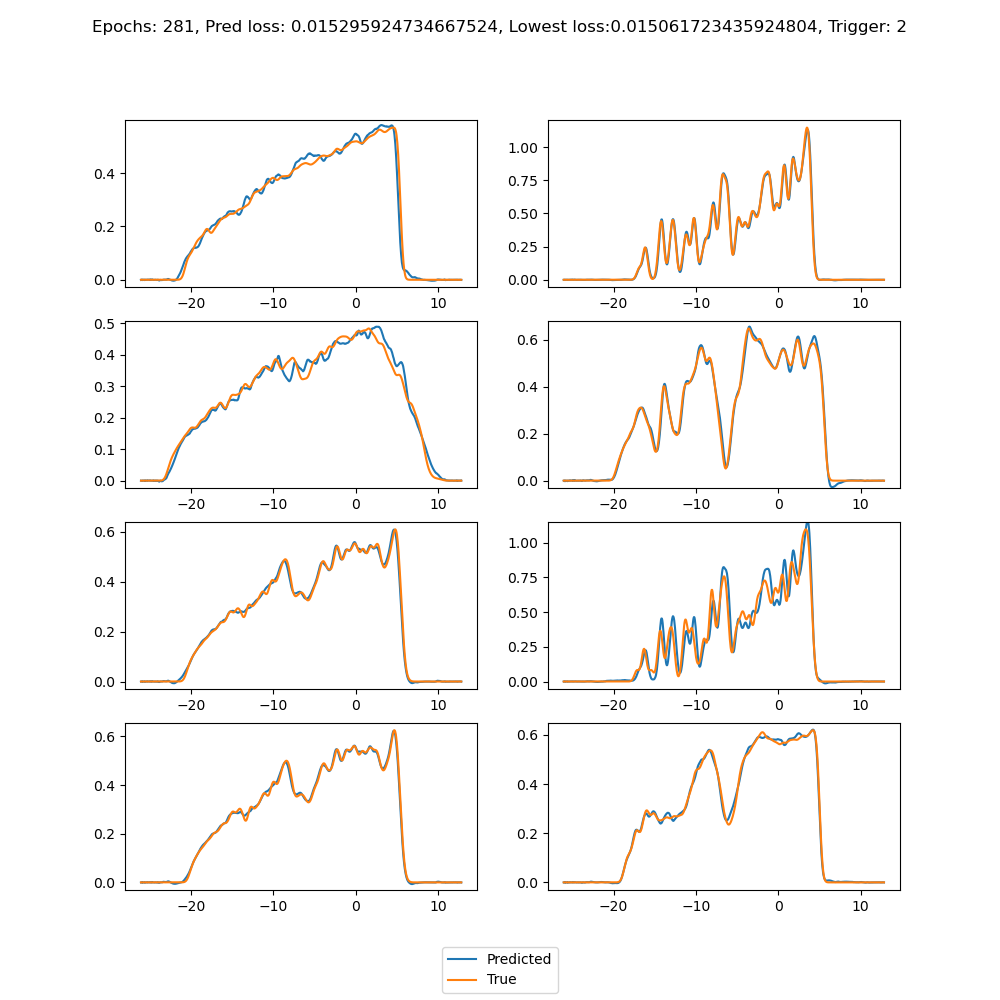

/tmp/ipykernel_4988/3216523151.py:42: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([line,z], labels = ["Predicted", "True"], loc = "lower center")
Epoch: 283:   3%|██▋                                                                                           | 283/10000 [12:19:34<8:24:11,  3.11s/it, lowest_loss=0.0151, pred_loss=0.000194, trigger=3]

In [ ]:
n_epochs = 10000
lr_model = 0.001
lr_alignment = 0.001

# if self.opt == "Adam":
opt_model = torch.optim.Adam(model1.parameters(), lr = lr_model, weight_decay = 0)
opt_alignment = torch.optim.Adam([soap_dataset.alignment], lr = lr_alignment, weight_decay = 0)
# if valdata_loader is not None:
#     threshold = 1000
#     scheduler_threshold = 100
# else:
threshold = 1000
scheduler_threshold = 100
tol = 1e-4
# if self.opt == "LBFGS":
#     opt = torch.optim.LBFGS(self.parameters(), lr = lr, line_search_fn = "strong_wolfe")
#     if valdata_loader is not None:
#         threshold = 2000
#         scheduler_threshold = 2000
#     else:
#         threshold = 30
#         scheduler_threshold = 5
#     tol = 1e-4
scheduler_model = torch.optim.lr_scheduler.ReduceLROnPlateau(opt_model, factor = 0.1, patience = scheduler_threshold)#0.5)
scheduler_alignment = torch.optim.lr_scheduler.ReduceLROnPlateau(opt_alignment, factor = 0.1, patience = scheduler_threshold)
best_state = copy.deepcopy(model1.state_dict())
lowest_loss = torch.tensor(9999)
pred_loss = torch.tensor(0)
trigger = 0
loss_history =[]
pbar = tqdm(range(n_epochs))

fig, ax_list = plt.subplots(4,2)
ax_list = ax_list.flatten()
lines = []
critical_indexes = np.arange(8)
#critical_indexes = np.array([369, 341, 745, 521, 278, 5, 193, 37])
for i in range(len(critical_indexes)):
    line, = ax_list[i].plot(model1.xdos.cpu(), reconstructed_ldos_t[train_index[critical_indexes[i]]], label = "Prediction")
    lines.append(line)
    z = ax_list[i].plot(model1.xdos.cpu(), reconstructed_ldos_t[train_index[critical_indexes[i]]], label = "True")
fig.legend([line,z], labels = ["Predicted", "True"], loc = "lower center")
for epoch in pbar:
    total_error = 0
    pbar.set_description(f"Epoch: {epoch}")
#     if valdata_loader is not None:
#         pbar.set_postfix(val_loss = lowest_loss.item(), trigger = trigger, train_loss = pred_loss.item())
#     else:
    pbar.set_postfix(pred_loss = pred_loss.item(), lowest_loss = lowest_loss.item(), trigger = trigger)

    for x_data, y_data in soap_dataloader:
        opt_model.zero_grad()
        opt_alignment.zero_grad()
        x_data, y_data = x_data.to(model1.device), y_data.to(model1.device)
#         if self.opt == "LBFGS":
#             def closure(predictions = False):
#                 """
#                 Function is necessary for LBFGS, returns the total loss of the model

#                 Args:
#                     predictions (bool, optional): Returns prediction loss if true, returns total loss if False

#                 Returns:
#                     tensor: Loss
#                 """
#                 opt.zero_grad()
#                 _pred = self.forward(x_data)
#                 _pred_loss = t_get_mse(_pred, y_data)#, self.xdos), perc = True)       
#                 _pred_loss *= 1e7
#                 #self.alignment = (self.alignment - 20) * (self.xdos[1] - self.xdos[0])
#                 _pred_loss = torch.nan_to_num(_pred_loss, nan=lowest_loss.item(), posinf = lowest_loss.item(), neginf = lowest_loss.item())                 
#                 _reg_loss = torch.sum(torch.pow(self.linear.weight,2))
#                 _reg_loss *= self.reg.item()
#                 _new_loss = _pred_loss + _reg_loss
#                 _new_loss.backward()
#                 # global z 
#                 # z = (torch.sum(abs(self.linear.weight.grad)))
#                 if predictions:
#                     return _pred_loss
#                 return _new_loss
#             opt.step(closure)
#             #print (z)
#             with torch.no_grad():
#                 pred = self.forward(x_data)
#                 pred_loss = t_get_rmse(pred, y_data)
#                 reg_loss = torch.sum(torch.pow(self.linear.weight,2))
#                 reg_loss *= self.reg.item()
#                 new_loss = pred_loss + reg_loss
#             if pred_loss >100000 or (pred_loss.isnan().any()) :
#                 print ("Optimizer shows weird behaviour, reinitializing at previous best_State")
#                 self.load_state_dict(best_state)
#                 opt = torch.optim.LBFGS(self.parameters(), lr = lr)
#             if epoch %10 == 1:
#                 loss_history.append(lowest_loss.item())
#         elif self.opt == "Adam":
        pred = model1.forward(x_data)

    
        pred_loss = loss.t_get_mse(pred, y_data)#, self.xdos, perc = True)
        total_error += pred_loss
        new_loss = 1E7 * pred_loss
        new_loss.backward()
        opt_model.step()
        opt_alignment.step()
        if pred_loss >100000 or (pred_loss.isnan().any()) :
            print ("Optimizer shows weird behaviour, reinitializing at previous best_State")
            model1.load_state_dict(best_state)
            opt = torch.optim.Adam(model1.parameters(), lr = lr, weight_decay = 0)

    with torch.no_grad():
        critical_pred = model1.forward(soap_dataset.X[critical_indexes])
        new_loss = total_error
        scheduler_model.step(new_loss)
        scheduler_alignment.step(new_loss)
        if lowest_loss - new_loss > tol: #threshold to stop training
            best_state = copy.deepcopy(model1.state_dict())
            lowest_loss = new_loss
            trigger = 0
        else:
            trigger +=1
        if epoch %1000 == 1:
            loss_history.append(lowest_loss.item())
        for i in range(len(critical_indexes)):
            lines[i].set_ydata(critical_pred[i].detach().numpy())
        fig.suptitle("Epochs: {}, Pred loss: {}, Lowest loss:{}, Trigger: {}".format(epoch, new_loss.item(), lowest_loss.item(), trigger))
        fig.canvas.draw()
        fig.canvas.flush_events()

        if trigger > threshold:
            model1.load_state_dict(best_state)
            print ("Implemented early stopping with lowest_loss: {}".format(lowest_loss))


In [12]:
def generate_energy_index(eigenenergy_length):
    n_structures = len(eigenenergy_length)
    total_index = []
    for i, e_vals in enumerate(eigenenergy_length):
        indiv_index = torch.zeros(e_vals) + i
        total_index.append(indiv_index)
    total_index = torch.hstack(total_index)
    return total_index.long()

In [13]:
energy_index = generate_energy_index(eigenenergy_length)

In [14]:
energies = torch.hstack(full_eigen_energies).view(-1,1)

In [15]:
def torch_generate_dos(energies, eigenenergy_length_t, normalization, splits):
    ldoses = []
    for i in tqdm(range(len(splits) - 1)):
        indexes = generate_energy_index(eigenenergy_length_t[splits[i]:splits[i+1]])
        E = energies[torch.sum(eigenenergy_length_t[:splits[i]]):torch.sum(eigenenergy_length_t[:splits[i]]) + torch.sum(eigenenergy_length_t[splits[i]:splits[i+1]])]
        split_ldos = torch.zeros(splits[i+1] - splits[i], len(xdos))
        
        new_ldos = (torch.exp(-0.5*((xdos - E)/sigma)**2))
        
        split_ldos.index_add_(0, indexes, new_ldos)
        
        ldoses.append(split_ldos)
    ldoses = torch.vstack(ldoses)     
    
    final_ldos = ((ldoses.T * normalization ).T)* 2
    return final_ldos
    


In [16]:
# ldos2 = torch_generate_dos(energies, eigenenergy_length_t, normalization, [0, 100, 200, 300, 400, 500, 800, 1039])

In [17]:
alignment.shape

torch.Size([435])

In [18]:
lr = 100
n_epochs = 1000



In [19]:
sigma = torch.tensor(0.3)
dx = 0.05

emin = -24.5537
emax = 11.3464


ndos = int((emax-emin+3) / dx) #number of points
xdos = torch.linspace(emin-1.5, emax+1.5, ndos) # extend the energy grid by 3eV 
ldos = torch.zeros((len(small_index), ndos))
for i in tqdm(range(len(small_index))):#for every structure    
    ldos[i] = torch.sum(torch.exp(-0.5*((alignment[i] + xdos - full_eigen_energies[small_index[i]].view(-1,1))/sigma)**2), dim = 0)

final_ldos = ((ldos.T * normalization ).T)* 2

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 435/435 [00:05<00:00, 75.96it/s]


In [20]:
loss = torch.sum((1 - torch.abs((torch.corrcoef(torch.hstack([kernel_features, final_ldos]).T)[0][1:])))**2)

In [21]:
print (loss)

tensor(212.8861, grad_fn=<SumBackward0>)


In [ ]:
lr = 0.01
alignment = torch.nn.parameter.Parameter(torch.zeros(len(small_index)))
n_epochs = 1000

optimizer = torch.optim.Adam(
                [alignment],
                lr=lr)#,  line_search_fn="strong_wolfe")

for i in tqdm(range(n_epochs)):
    def closure():
        optimizer.zero_grad()
        sigma = torch.tensor(0.3)
        dx = 0.05

        emin = -24.5537
        emax = 11.3464


        ndos = int((emax-emin+3) / dx) #number of points
        xdos = torch.linspace(emin-1.5, emax+1.5, ndos) # extend the energy grid by 3eV 
        ldos = torch.zeros((len(small_index), ndos))
        for i in (range(len(small_index))):#for every structure    
            ldos[i] = torch.sum(torch.exp(-0.5*((alignment[i] + xdos - full_eigen_energies[small_index[i]].view(-1,1))/sigma)**2), dim = 0)

        final_ldos = ((ldos.T * normalization ).T)* 2
        pc_loss = torch.sum((1 - torch.abs((torch.corrcoef(torch.hstack([kernel_features, final_ldos]).T)[0][1:])))**2)
        #print (pc_loss)
        pc_loss.backward()
        return pc_loss
    
    mse = optimizer.step(closure)
    
    print (mse)

  0%|▏                                                                                                                                                                  | 1/1000 [00:09<2:45:56,  9.97s/it]

tensor(212.8861, grad_fn=<SumBackward0>)


  0%|▎                                                                                                                                                                  | 2/1000 [00:21<2:56:37, 10.62s/it]

tensor(212.1835, grad_fn=<SumBackward0>)


  0%|▍                                                                                                                                                                  | 3/1000 [00:29<2:41:25,  9.71s/it]

tensor(207.9559, grad_fn=<SumBackward0>)


  0%|▋                                                                                                                                                                  | 4/1000 [00:37<2:27:05,  8.86s/it]

tensor(204.2679, grad_fn=<SumBackward0>)


  0%|▊                                                                                                                                                                  | 5/1000 [00:45<2:25:24,  8.77s/it]

tensor(202.9791, grad_fn=<SumBackward0>)


  1%|▉                                                                                                                                                                  | 6/1000 [00:54<2:23:37,  8.67s/it]

tensor(203.2197, grad_fn=<SumBackward0>)


  1%|█▏                                                                                                                                                                 | 7/1000 [01:02<2:21:07,  8.53s/it]

tensor(203.7145, grad_fn=<SumBackward0>)


  1%|█▎                                                                                                                                                                 | 8/1000 [01:10<2:20:22,  8.49s/it]

tensor(203.2850, grad_fn=<SumBackward0>)


  1%|█▍                                                                                                                                                                 | 9/1000 [01:18<2:16:03,  8.24s/it]

tensor(202.0296, grad_fn=<SumBackward0>)


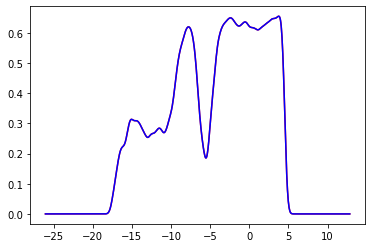

In [80]:
%matplotlib inline
index = 50
plt.plot(xdos, o_ldos[small_index[index]], c = 'r')
plt.plot(xdos, final_ldos[index].detach(), c = 'b')

torch.corrcoef
torch.var

In [24]:
tol = 1E-4
print (torch.sum(test_ldos > tol))

plt.plot(xdos[(test_ldos > tol)], test_ldos[(test_ldos > tol)])

tensor(552253)


NameError: name 'test_ldos' is not defined

In [22]:
len(xdos[(test_ldos > tol)])

NameError: name 'test_ldos' is not defined

In [212]:
ldos[0]

tensor([6.3422e-155, 5.0089e-153, 3.8472e-151, 2.8738e-149, 2.0878e-147,
        1.4751e-145, 1.0136e-143, 6.7735e-142, 4.4023e-140, 2.7826e-138,
        1.7105e-136, 1.0226e-134, 5.9460e-133, 3.3623e-131, 1.8491e-129,
        9.8900e-128, 5.1445e-126, 2.6026e-124, 1.2805e-122, 6.1272e-121,
        2.8514e-119, 1.2906e-117, 5.6807e-116, 2.4319e-114, 1.0125e-112,
        4.0999e-111, 1.6146e-109, 6.1840e-108, 2.3035e-106, 8.3453e-105,
        2.9404e-103, 1.0076e-101, 3.3580e-100,  1.0885e-98,  3.4313e-97,
         1.0520e-95,  3.1370e-94,  9.0977e-93,  2.5661e-91,  7.0396e-90,
         1.8782e-88,  4.8739e-87,  1.2301e-85,  3.0194e-84,  7.2086e-83,
         1.6738e-81,  3.7801e-80,  8.3031e-79,  1.7738e-77,  3.6858e-76,
         7.4489e-75,  1.4642e-73,  2.7993e-72,  5.2054e-71,  9.4147e-70,
         1.6562e-68,  2.8339e-67,  4.7164e-66,  7.6348e-65,  1.2021e-63,
         1.8411e-62,  2.7426e-61,  3.9740e-60,  5.6011e-59,  7.6789e-58,
         1.0240e-56,  1.3284e-55,  1.6761e-54,  2.0

In [154]:
sigma = torch.tensor(0.3)
dx = 0.05

ndos = int((emax-emin+3) / dx) #number of points
xdos = torch.linspace(emin-1.5, emax+1.5, ndos) # extend the energy grid by 3eV 
ldos = torch.zeros((len(full_eigen_energies), ndos))
for i in tqdm(range(len(full_eigen_energies))):#for every structure    
    for ei in full_eigen_energies[i]:#for every energy level
        ldos[i] += torch.exp(-0.5*((xdos[:]-ei)/sigma)**2) #puts a gaussian centered on the energy level
    ldos[i] *= 1/torch.sqrt(2*torch.tensor(np.pi)*sigma**2)/n_atoms[i]/len(full_eigen_energies[i]) #normalize

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1039/1039 [13:33<00:00,  1.28it/s]


In [181]:
sigma = torch.tensor(0.3)
dx = 0.05

ndos3 = int((emax-emin+3) / dx) #number of points
xdos3 = torch.linspace(emin-1.5, emax+1.5, ndos) # extend the energy grid by 3eV 
ldos3 = torch.zeros((len(full_eigen_energies), ndos))
for i in tqdm(range(len(eigen_energies))):#for every structure    
    for ei in full_eigen_energies[i]:#for every energy level
        ldos3[i] += torch.exp(-0.5*((xdos[:]-ei)/sigma)**2) #puts a gaussian centered on the energy level
    ldos3[i] *= 1/torch.sqrt(2*np.pi*sigma**2)/n_atoms[i]/len(eigen_energies[i]) #normalize

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1039/1039 [13:40<00:00,  1.27it/s]


In [139]:
from sklearn.decomposition import PCA

soap = Silicon.Features['structure_avedescriptors'] 
soap_pca = PCA(n_components = 1, svd_solver = "full")
soap_pca.fit(soap)

print ("SOAP PCA explained variance with 1 PCA is: {}".format(soap_pca.explained_variance_ratio_))

PCA_soap = soap_pca.transform(soap)

kernel = Silicon.Features['structure_avekerneldescriptors']
kernel_pca = PCA(n_components = 1, svd_solver = "full")
kernel_pca.fit(kernel)

print ("Kernel PCA explained variance with 1 PCA is: {}".format(kernel_pca.explained_variance_ratio_))

PCA_kernel = kernel_pca.transform(kernel)

SOAP PCA explained variance with 1 PCA is: [0.85417772]
Kernel PCA explained variance with 1 PCA is: [0.76640756]


In [146]:
soap_pca.components_

array([[-3.49913423e-03, -1.76411215e-02,  3.32522948e-02,
         3.61629233e-01,  1.87222390e-01,  7.49472932e-02,
         7.73753721e-02,  2.89413546e-02, -1.76411215e-02,
         7.01613627e-04, -6.64714922e-03, -1.96539716e-02,
        -1.21993389e-02, -6.67081254e-03, -4.36700539e-03,
        -1.68577363e-03,  3.32522948e-02, -6.64714922e-03,
         2.20352739e-02,  1.41889410e-01,  7.26851954e-02,
         3.15241013e-02,  2.88627511e-02,  1.08549650e-02,
         3.61629233e-01, -1.96539716e-02,  1.41889410e-01,
         4.92546963e-01,  2.89406316e-01,  1.51981690e-01,
         1.06534352e-01,  4.10607729e-02,  1.87222390e-01,
        -1.21993389e-02,  7.26851954e-02,  2.89406316e-01,
         1.62030561e-01,  8.08235013e-02,  6.02749031e-02,
         2.31914869e-02,  7.49472932e-02, -6.67081254e-03,
         3.15241013e-02,  1.51981690e-01,  8.08235013e-02,
         3.70043392e-02,  3.02939232e-02,  1.15274716e-02,
         7.73753721e-02, -4.36700539e-03,  2.88627511e-0

## Baseline Model (SOAP)

In [325]:
from sklearn.linear_model import Ridge
from dostools.loss import loss
from dostools.consistency import consistency

Features = copy.deepcopy(PCA_kernel)
o_ldos = torch.tensor(data.load_ldos())
o_ldos *= 2
y_pw = o_ldos# - o_ldos[train_index].mean(axis = 0)
y_shifted = copy.deepcopy(y_pw)
#y_shifted = consistency.shifted_ldos()

baselinemodel = Ridge(alpha = 0, fit_intercept = True, solver = 'svd')

x = Features[train_index]
y = y_shifted[train_index]

baselinemodel.fit(x,y)

baseline_predictions = baselinemodel.predict(x)
train_rmse = loss.t_get_rmse(torch.tensor(baseline_predictions), y)

# small_test_index = torch.arange(1039)
# small_test_index[small_index] = False
# small_test_index = small_test_index.nonzero().flatten()


baseline_test_predictions = baselinemodel.predict(Features[test_index])
test_rmse = loss.t_get_rmse(torch.tensor(baseline_test_predictions), y_shifted[test_index])

print(train_rmse)
print(test_rmse)

tensor(0.0613)
tensor(0.0636)


## Misc Visualizations

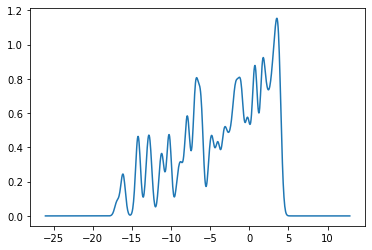

In [326]:
plt.plot(xdos, ldos[700])

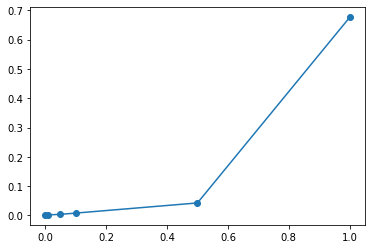

In [194]:
plt.plot(np.array([1,0.5,0.1,0.05,0.01,0.001]), np.array([0.6768, 0.0426, 0.0079, 0.0036, 0.0019, 0.0017]))
plt.scatter(np.array([1,0.5,0.1,0.05,0.01,0.001]), np.array([0.6768, 0.0426, 0.0079, 0.0036, 0.0019, 0.0017]))

In [ ]:
1
tensor(24)
tensor(0.6768)

5E-1
tensor(49)
tensor(0.0426)


1E-1
tensor(245)
tensor(0.0079)

5E-2
tensor(484)
tensor(0.0036)

1E-2 
tensor(2149)
tensor(0.0019)

1E-3
tensor(7013)
tensor(0.0017)